## Feature Selection 기법

***Recursive Feature Elimination***
* feature importance가 낮은 속성들을 차례로 제거해 가면서 반복적으로 fit-predict를 수행하여 최적 feature 추출
* 수행시간이 오래 걸리고, 중요도가 낮은 속성들을 제거해 나가는 메커니즘이 정확한 Feature Selection을 찾는 목표에 부합하지 않을수도..

In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification

# 분류를 위한 Feature의 개수가 25개인 데이터 1000개 생성
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# classifier로 SVC 선택
svc = SVC(kernel='linear')

In [3]:
from sklearn.feature_selection import RFECV, RFE

# Recursive Feature Elimination + CV로 Feature들을 반복적으로 제거해나가면서 학습/평가 수행
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',verbose=2)
rfecv.fit(X,y)

# optimal number of features
rfecv.n_features_

Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.


3

C:\Users\happy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


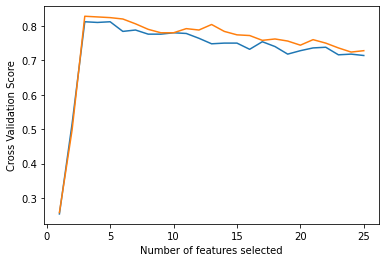

In [5]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross Validation Score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

feature가 3개일 때 accuracy 높음

In [ ]:
# Build a classification task - this time 10000 samples
# 학습/평가를 반복하는데 시간이 너무 오래 걸린다는 단점 존재

***Select From Model***

In [7]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X,y = diabetes.data, diabetes.target

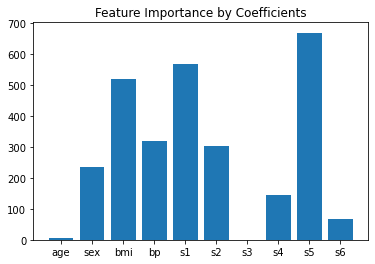

In [8]:
import numpy as np
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X,y)
importance = np.abs(lasso.coef_) # 회귀 계수를 중요도로 설정
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title('Feature Importance by Coefficients')
plt.show()

In [9]:
from sklearn.feature_selection import SelectFromModel

# feature를 선정할 임계값 선정
threshold = np.sort(importance)[-3] + 0.01
print(f'threshold = {threshold}')

threshold = 521.754369295439


In [11]:
sfm = SelectFromModel(lasso, threshold=threshold).fit(X,y)
print(f'Features selected by SFM : {feature_names[sfm.get_support()]}')

Features selected by SFM : ['s1' 's5']


***Permutation Importance***

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

In [25]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [26]:
diabletes = load_diabetes()
X_train, X_val, y_train, y_val = train_test_split(diabetes.data, diabetes.target, random_state=0)

model = Ridge(alpha=1e-2).fit(X_train, y_train)
y_pred = model.predict(X_val)
print(r2_score(y_val, y_pred))

0.3566675322939423


In [27]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)

In [29]:
r.importances_mean

array([-0.00199237,  0.05587285,  0.17579633,  0.08836144,  0.04219777,
        0.00203309,  0.00203936,  0.00318738,  0.20422681,  0.00278711])

In [31]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(diabetes.feature_names[i], np.round(r.importances_mean[i],4))

s5 0.2042
bmi 0.1758
bp 0.0884
sex 0.0559


**Permutation Importance vs Random Forest Feature Importance**

* rf feature importance는 최적 tree 구조를 만들기 위한 피쳐들의 impurity (지니 계수)가 중요 기준. 즉, 결정 값(target)과 관련이 없어도 높아질 수 있음